In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
t_df = pd.read_csv("Tickets.csv")
f_df = pd.read_csv("Flights.csv")
a_df = pd.read_csv("Airport_Codes.csv")

In [7]:
f_df["FL_DATE"] = pd.to_datetime(f_df["FL_DATE"], format='mixed')

In [8]:
f_df = f_df[f_df["CANCELLED"] == 0]

In [9]:
print("Data Quality Insights:")
print("Missing Values:\n", f_df.isnull().sum())

Data Quality Insights:
Missing Values:
 FL_DATE                 0
OP_CARRIER              0
TAIL_NUM                0
OP_CARRIER_FL_NUM       0
ORIGIN_AIRPORT_ID       0
ORIGIN                  0
ORIGIN_CITY_NAME        0
DEST_AIRPORT_ID         0
DESTINATION             0
DEST_CITY_NAME          0
DEP_DELAY               0
ARR_DELAY            4377
CANCELLED               0
AIR_TIME             5027
DISTANCE              610
OCCUPANCY_RATE        310
dtype: int64


In [10]:
print("Duplicate Entries:", f_df.duplicated().sum())

Duplicate Entries: 4410


In [11]:
print("Outliers in Distance:", f_df["DISTANCE"].describe())

Outliers in Distance: count     1863662.0
unique       1956.0
top           337.0
freq        12797.0
Name: DISTANCE, dtype: float64


In [12]:
def merge_datasets(f_df, a_df):
    a_df = a_df[["IATA_CODE", "TYPE"]] 
    f_df = f_df.merge(a_df, left_on="ORIGIN", right_on="IATA_CODE", how="left")
    f_df = f_df.rename(columns={"TYPE": "ORIGIN_TYPE"})
    f_df = f_df.merge(a_df, left_on="DESTINATION", right_on="IATA_CODE", how="left")
    f_df = f_df.rename(columns={"TYPE": "DEST_TYPE"})
    return f_df

f_df = merge_datasets(f_df, a_df)

In [13]:
f_df = f_df[(f_df["ORIGIN_TYPE"].isin(["medium_airport", "large_airport"])) &
                      (f_df["DEST_TYPE"].isin(["medium_airport", "large_airport"]))]

In [14]:
f_df["ROUND_TRIP"] = f_df.apply(lambda x: "-".join(sorted([x["ORIGIN"], x["DESTINATION"]])), axis=1)

In [15]:
busy_routes = f_df.groupby("ROUND_TRIP").size().reset_index(name="flight_count")
busy_routes = busy_routes.sort_values(by="flight_count", ascending=False).head(10)

In [16]:
print("Busiest Routes:\n", busy_routes)

Busiest Routes:
      ROUND_TRIP  flight_count
2194    LAX-SFO          8340
2235    LGA-ORD          7156
2098    LAS-LAX          6511
2039    JFK-LAX          6320
2193    LAX-SEA          4999
554     BOS-LGA          4820
1795    HNL-OGG          4794
2660    PDX-SEA          4774
193     ATL-MCO          4707
189     ATL-LGA          4594


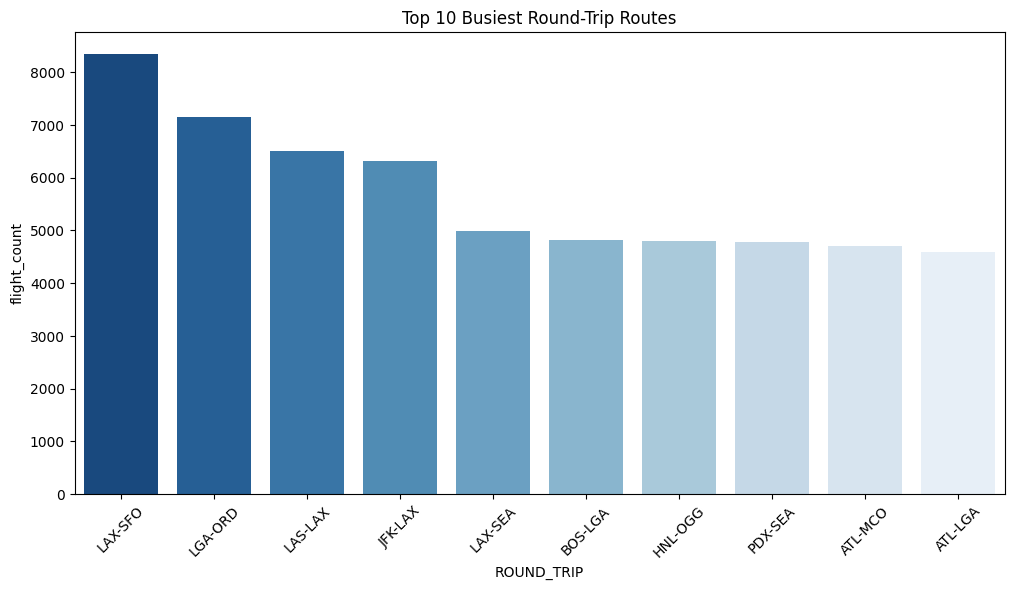

In [17]:
plt.figure(figsize=(12,6))
sns.barplot(data=busy_routes, x="ROUND_TRIP", y="flight_count", palette="Blues_r")
plt.xticks(rotation=45)
plt.title("Top 10 Busiest Round-Trip Routes")
plt.show()

In [18]:
f_df["OCCUPANCY_RATE"] = pd.to_numeric(f_df["OCCUPANCY_RATE"], errors='coerce')
f_df["DISTANCE"] = pd.to_numeric(f_df["DISTANCE"], errors='coerce')
f_df.dropna(subset=["OCCUPANCY_RATE", "DISTANCE"], inplace=True)
f_df["Revenue"] = f_df["OCCUPANCY_RATE"] * 200 * (f_df["DISTANCE"] * 0.5 * 35 + f_df["DISTANCE"])
f_df["Cost"] = (f_df["DISTANCE"] * (8 + 1.18)) + \
                     (5000 * (f_df["ORIGIN_TYPE"] == "medium_airport")) + \
                     (10000 * (f_df["ORIGIN_TYPE"] == "large_airport"))

In [19]:
f_df["Delay_Cost"] = np.where(f_df["DEP_DELAY"] > 15, (f_df["DEP_DELAY"] - 15) * 75, 0) + \
                          np.where(f_df["ARR_DELAY"] > 15, (f_df["ARR_DELAY"] - 15) * 75, 0)
f_df["Total_Cost"] = f_df["Cost"] + f_df["Delay_Cost"]
f_df["Profit"] = f_df["Revenue"] - f_df["Total_Cost"]
profit_routes = f_df.groupby("ROUND_TRIP")[["Revenue", "Total_Cost", "Profit"]].sum().reset_index()
profit_routes = profit_routes.sort_values(by="Profit", ascending=False).head(10)

In [20]:
print("Most Profitable Routes:\n", profit_routes)

Most Profitable Routes:
      ROUND_TRIP       Revenue    Total_Cost        Profit
2039    JFK-LAX  3.762331e+10  2.149494e+08  3.740836e+10
2067    JFK-SFO  2.313686e+10  1.336451e+08  2.300322e+10
1788    HNL-LAX  1.678804e+10  9.578182e+07  1.669226e+10
2175    LAX-ORD  1.557145e+10  1.034489e+08  1.546800e+10
1599    EWR-SFO  1.495105e+10  8.822635e+07  1.486282e+10
580     BOS-SFO  1.473467e+10  8.552681e+07  1.464914e+10
553     BOS-LAX  1.449627e+10  8.280817e+07  1.441346e+10
186     ATL-LAX  1.411299e+10  8.876064e+07  1.402423e+10
1562    EWR-LAX  1.254447e+10  7.196123e+07  1.247251e+10
2235    LGA-ORD  1.259806e+10  1.416502e+08  1.245641e+10


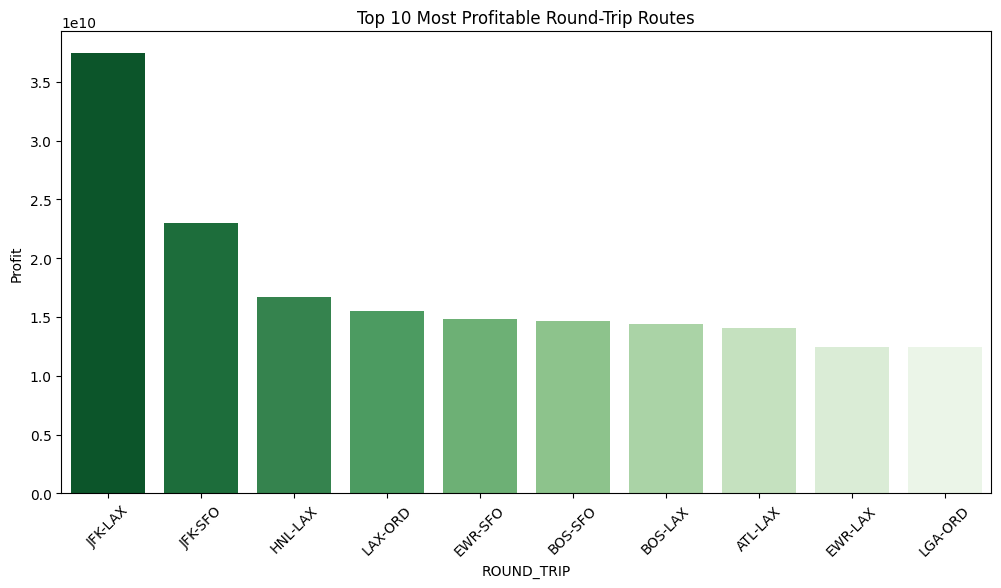

In [21]:
plt.figure(figsize=(12,6))
sns.barplot(data=profit_routes, x="ROUND_TRIP", y="Profit", palette="Greens_r")
plt.xticks(rotation=45)
plt.title("Top 10 Most Profitable Round-Trip Routes")
plt.show()

In [22]:
best_routes = profit_routes.head(5)

In [23]:
print("Recommended Routes:\n", best_routes)

Recommended Routes:
      ROUND_TRIP       Revenue    Total_Cost        Profit
2039    JFK-LAX  3.762331e+10  2.149494e+08  3.740836e+10
2067    JFK-SFO  2.313686e+10  1.336451e+08  2.300322e+10
1788    HNL-LAX  1.678804e+10  9.578182e+07  1.669226e+10
2175    LAX-ORD  1.557145e+10  1.034489e+08  1.546800e+10
1599    EWR-SFO  1.495105e+10  8.822635e+07  1.486282e+10


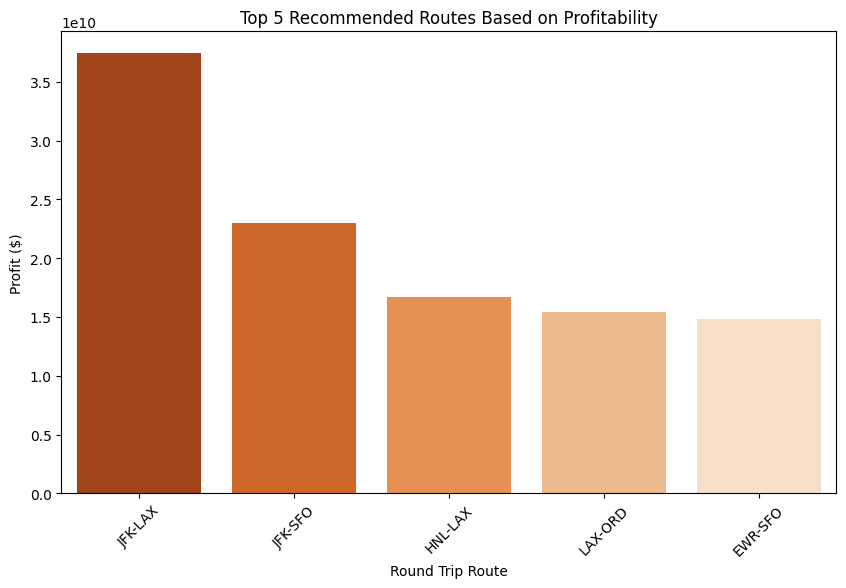

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(data=best_routes, x='ROUND_TRIP', y='Profit', palette='Oranges_r')
plt.xticks(rotation=45)
plt.xlabel('Round Trip Route')
plt.ylabel('Profit ($)')
plt.title('Top 5 Recommended Routes Based on Profitability')
plt.show()

In [25]:
best_routes = best_routes.copy()
best_routes["Breakeven_Flights"] = np.ceil(90000000 / best_routes["Profit"])  # $90M per plane

In [26]:
print("Break-even Calculation Results:", best_routes[["ROUND_TRIP", "Breakeven_Flights"]])

Break-even Calculation Results:      ROUND_TRIP  Breakeven_Flights
2039    JFK-LAX                1.0
2067    JFK-SFO                1.0
1788    HNL-LAX                1.0
2175    LAX-ORD                1.0
1599    EWR-SFO                1.0


In [27]:
kpis = {
    "On-time Performance": "Percentage of flights arriving on time",
    "Load Factor": "Average occupancy rate of flights",
    "Revenue per Mile": "Total revenue divided by total distance flown",
    "Cost per Mile": "Total operating cost divided by total distance flown",
    "Customer Satisfaction": "Survey-based rating of customer experience"
}

In [28]:
print("Key Performance Indicators:\n", kpis)

Key Performance Indicators:
 {'On-time Performance': 'Percentage of flights arriving on time', 'Load Factor': 'Average occupancy rate of flights', 'Revenue per Mile': 'Total revenue divided by total distance flown', 'Cost per Mile': 'Total operating cost divided by total distance flown', 'Customer Satisfaction': 'Survey-based rating of customer experience'}
